In [1]:
# !pip install supervision 
# !pip install ultralytics
# ! pip install timm einops roboflow

In [2]:

import os

os.environ["ROBOFLOW_API_KEY"] = "hXAkIGWlq7TG9jZkW32N"
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

In [3]:


from roboflow import Roboflow

In [4]:


rf = Roboflow(api_key="hXAkIGWlq7TG9jZkW32N")


In [5]:
project = rf.workspace("roboflow-jvuqo").project("poker-cards-fmjio")
version = project.version(4)
dataset = version.download("florence2-od")

loading Roboflow workspace...
loading Roboflow project...


In [6]:


dataset.name


'poker cards'

In [7]:

import torch



from transformers import AutoModelForCausalLM, AutoTokenizer, AutoProcessor


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [8]:


# model_id = "microsoft/Florence-2-base-ft"
model_id = "/root/autodl-tmp/modelscope_cache/hub/AI-ModelScope/Florence-2-base-ft"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).to(device)

processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

Importing from timm.models.layers is deprecated, please import via timm.layers
Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [9]:

import supervision as sv
from PIL import Image



In [10]:
"""展示推理过程"""

image_path = "poker-cards-4/train/IMG_20220316_134551_jpg.rf.2934cd1005d243fad04c2b4c8dd86bf0.jpg"

image = Image.open(image_path)
# 目标检测任务
task = "<OD>"
text = "<OD>"

inputs = processor(text=text, images=image, return_tensors="pt").to(device)

generated_ids = model.generate(input_ids=inputs["input_ids"],
                              pixel_values=inputs["pixel_values"],
                              max_new_tokens=1024,
                              num_beams=3)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=image.size)

detections = sv.Detections.from_lmm(lmm=sv.LMM.FLORENCE_2, 
                                   result=response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)

label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)


new_image = bounding_box_annotator.annotate(image, detections)
new_image2 = label_annotator.annotate(new_image, detections)



SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


In [11]:
new_image2
"""
打印上述new_image2可以看出来， 基本没有识别出来
"""
print()

In [12]:


# 使用lora fine tuning

from peft import LoraConfig, get_peft_model

target_modules = [
    "q_proj", "o_proj", "k_proj", "v_proj", 
    "linear", "Conv2d", "lm_head", "fc2"
]


config  = LoraConfig(r=8, lora_alpha=8, target_modules=target_modules,
                    task_type="CAUSAL_LM", lora_dropout=0.05,
                    bias='none',
                    inference_mode=False, use_rslora=True,
                    init_lora_weights="gaussian")


peft_model = get_peft_model(model, config)

peft_model.print_trainable_parameters()




trainable params: 1,929,928 || all params: 272,733,896 || trainable%: 0.7076


In [13]:
from typing import List, Dict, Any, Tuple

from PIL import Image

from torch.utils.data import Dataset, DataLoader

class JSONLDataset:
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self) -> List[Dict[str, Any]]:
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self) -> int:
        return len(self.entries)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, Dict[str, Any]]:
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        try:
            image = Image.open(image_path)
            return (image, entry)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image file {image_path} not found.")


class DetectionDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.dataset = JSONLDataset(jsonl_file_path, image_directory_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, data = self.dataset[idx]
        prefix = data['prefix']
        suffix = data['suffix']
        return prefix, suffix, image





In [14]:
import json

BATCH_SIZE = 6
NUM_WORKERS = 0

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(device)
    return inputs, answers

train_dataset = DetectionDataset(
    jsonl_file_path = f"{dataset.location}/train/annotations.jsonl",
    image_directory_path = f"{dataset.location}/train/"
)
val_dataset = DetectionDataset(
    jsonl_file_path = f"{dataset.location}/valid/annotations.jsonl",
    image_directory_path = f"{dataset.location}/valid/"
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)
     


In [15]:
torch.cuda.empty_cache()


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


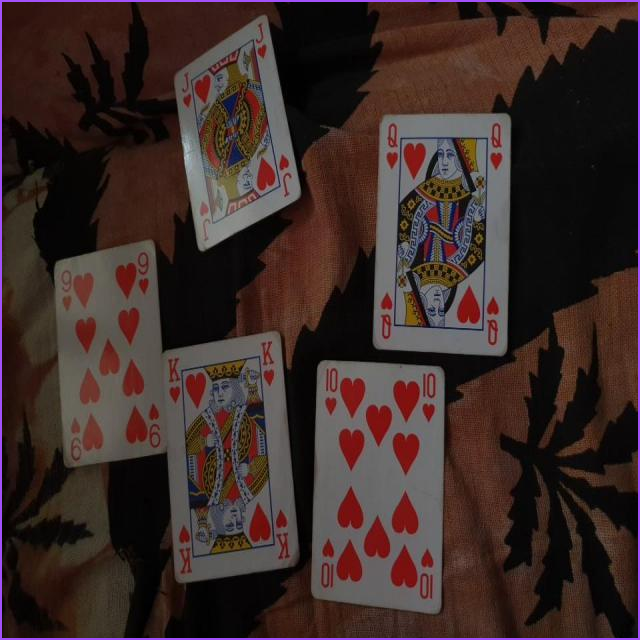

{'<OD>': {'bboxes': [[0.3199999928474426,
    0.3199999928474426,
    639.0399780273438,
    639.0399780273438]],
  'labels': ['bed']}}

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


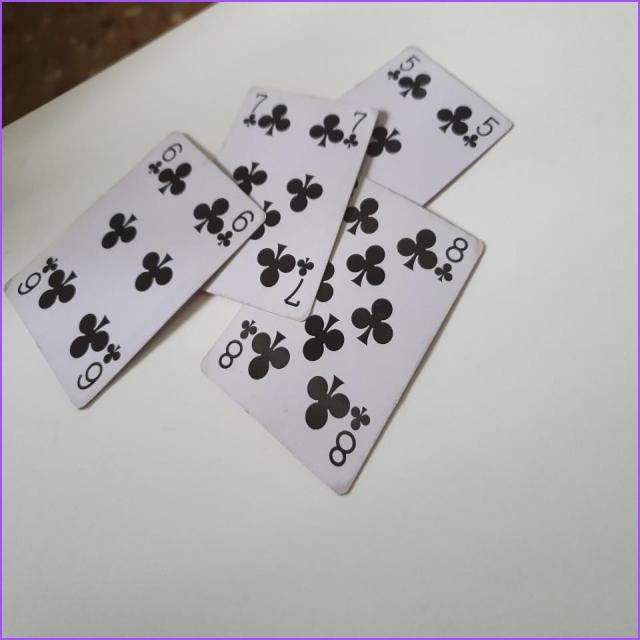

{'<OD>': {'bboxes': [[0.3199999928474426,
    0.3199999928474426,
    639.0399780273438,
    639.0399780273438]],
  'labels': ['table']}}

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


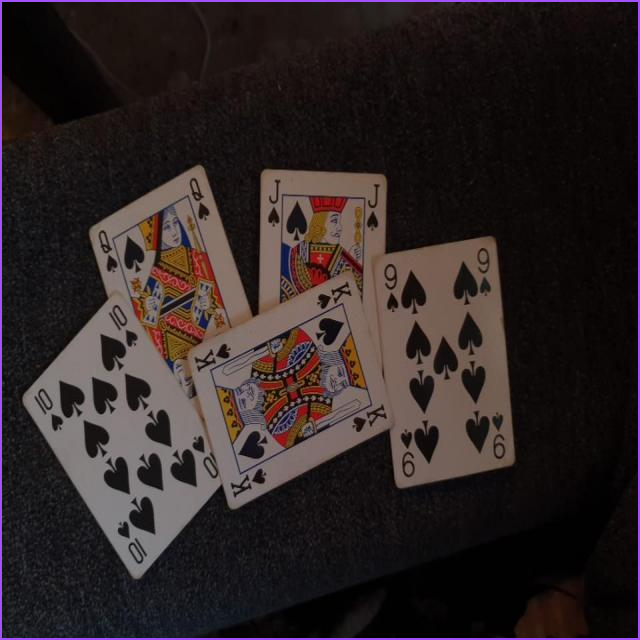

{'<OD>': {'bboxes': [[0.3199999928474426,
    0.3199999928474426,
    639.0399780273438,
    639.0399780273438]],
  'labels': ['chair']}}

In [16]:
"""渲染图片及标注结果"""
import io
import base64
import html

from IPython.display import display, HTML

def render_inline(image: Image.Image, resize=(128, 128)):
    """转换图片image为html"""

    image.resize(resize)
    with io.BytesIO() as buffer:
        image.saev(buffer, format="jpeg")
        image_ba64 = str(base64.b64encode(buffer.get_value()), "utf-8")


        return f"data:image/jpeg;base64,{image_b64}"


def render_example(image: Image.Image, response):
    try:
        detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size
                                           )
        image = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image.copy(),detections )

        image = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image, detections)

        display(image, response)
    except Exception as e:
        print("failed to render model response")
        print(e)
        
    return f"""

    
    {html.escape(json.dumps(response))}

"""


def render_inference_results(model, dataset: DetectionDataset, count:int):
    html_out = ""

    count = min(count, len(dataset))
    for i in range(count):
        image, data = dataset.dataset[i]
        prefix = data["prefix"]
        suffix = data["suffix"]
        inputs = processor(text=prefix, images=image, return_tensors="pt").to(device)
        generated_ids = model.generate(input_ids=inputs["input_ids"],
                                      pixel_values=inputs["pixel_values"],
                                      max_new_tokens=1024,
                                      num_beams=3)

        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
        answer = processor.post_process_generation(generated_text, task="<OD>", image_size=image.size)
        html_out += render_example(image, answer)


    display(HTML(html_out))


render_inference_results(peft_model, val_dataset, 3)


In [17]:
print(len(train_dataset))
print(len(val_dataset))

811
44


In [18]:


"""
在自定义数据集上微调
"""

# from torch.optim import AdamW

from tqdm import tqdm

from transformers import AdamW, get_scheduler, get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup

def train_custom_model(train_loader, val_loader,model, processor, epoches=10, lr=1e-6):

    optimizer = AdamW(params=model.parameters(),lr=lr, eps=1e-10)

    num_training_steps = epoches * len(train_dataset)
    lr_scheduler = get_scheduler(name="linear", optimizer=optimizer,
                                num_warmup_steps=0,
                                num_training_steps=num_training_steps)

    # render_inference_results(peft_model, val_loader.dataset, 6)

    for epoch_index in range(epochs):
        model.train()

        train_loss = 0
        for inputs, answer in tqdm(train_loader, desc=f"Training Epoch {epoch_index+1}"):
            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(text=answer, return_tensors="pt",
                                        padding=True, return_token_type_ids=False).input_ids.to(device)
            outputs = model(input_ids=input_ids, pixel_values=pixel_values,labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            train_loss += loss.item()

        avg_train_loss = train_loss /len(train_loader)
        print(f"Average Train losss: {avg_train_loss}")
        # 一轮训练结束即评估

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, answers in tqdm(val_loader, desc=f"Valid dataset Eval: {epoch_index+1}"):
                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True,
                                            return_token_type_ids=False).input_ids.to(device)
                # outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                
                loss = outputs.loss
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        print(f"Average Valid Loss: {avg_val_loss}")

        output_dir = f"./model_checkpoint/epoche_{epoch_index+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)
            

    


In [19]:
epochs = 10
lr = 1e-5

train_custom_model(train_loader, val_loader, peft_model, processor, epochs, lr)


Training Epoch 1: 100%|██████████| 136/136 [01:18<00:00,  1.74it/s]


Average Train losss: 4.113119737190359


Valid dataset Eval: 1: 100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


Average Valid Loss: 2.475823849439621


Training Epoch 2: 100%|██████████| 136/136 [01:17<00:00,  1.76it/s]


Average Train losss: 2.0196408603121254


Valid dataset Eval: 2: 100%|██████████| 8/8 [00:03<00:00,  2.65it/s]


Average Valid Loss: 1.6120431870222092


Training Epoch 3: 100%|██████████| 136/136 [01:17<00:00,  1.75it/s]


Average Train losss: 1.5914758706794065


Valid dataset Eval: 3: 100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


Average Valid Loss: 1.525747388601303


Training Epoch 4: 100%|██████████| 136/136 [01:17<00:00,  1.75it/s]


Average Train losss: 1.5018074074212242


Valid dataset Eval: 4: 100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


Average Valid Loss: 1.4789924025535583


Training Epoch 5: 100%|██████████| 136/136 [01:18<00:00,  1.73it/s]


Average Train losss: 1.4389016154934378


Valid dataset Eval: 5: 100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


Average Valid Loss: 1.4474927932024002


Training Epoch 6: 100%|██████████| 136/136 [01:17<00:00,  1.75it/s]


Average Train losss: 1.3935615972560995


Valid dataset Eval: 6: 100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


Average Valid Loss: 1.4331681281328201


Training Epoch 7: 100%|██████████| 136/136 [01:18<00:00,  1.73it/s]


Average Train losss: 1.3686052166363771


Valid dataset Eval: 7: 100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


Average Valid Loss: 1.4206564277410507


Training Epoch 8: 100%|██████████| 136/136 [01:19<00:00,  1.72it/s]


Average Train losss: 1.3489418625831604


Valid dataset Eval: 8: 100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


Average Valid Loss: 1.412131741642952


Training Epoch 9: 100%|██████████| 136/136 [01:17<00:00,  1.75it/s]


Average Train losss: 1.3236661421902038


Valid dataset Eval: 9: 100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


Average Valid Loss: 1.4025345742702484


Training Epoch 10: 100%|██████████| 136/136 [01:17<00:00,  1.75it/s]


Average Train losss: 1.3158558247720493


Valid dataset Eval: 10: 100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


Average Valid Loss: 1.3929752558469772
